### Import dependencies

In [11]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from featurizations import featurizations
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500 # Resolution of figures
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.loc"] = 'best'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [13]:
# Read in .parquet file of all reactions as a pandas dataframe
all_rxns_df = pd.read_parquet('../../data/processed/00_all_rxns_ready_to_fingerprint.parquet')

# Read in cofactors
all_cofactors_wo_stereo_filepath = '../../data/processed/expanded_cofactors_no_stereochem.tsv'
cofactors_df = pd.read_csv(all_cofactors_wo_stereo_filepath, delimiter=',')
all_cofactors_wo_stereo = set(cofactors_df['SMILES'])

filepath = '../../data/processed/all_processed_rxns_with_thermo_labelled_crit_DF_10.pkl'

In [14]:
with open(filepath, 'rb') as file:
    data = pickle.load(file)

### Helper function

In [15]:
def get_rule_CDF(df):
    all_rule_numbers = []
    all_proportions = []

    for i in range(1,1225):
        rule_number = f'rule{str(i).zfill(4)}'
        try:
            proportion = list(df[df['Rule'] == rule_number]['Proportion'])[0]
        except IndexError:
            proportion = 0

        all_rule_numbers.append(i)
        all_proportions.append(proportion)
        
    cumulative_frequencies = np.cumsum(all_proportions)
    
    return all_rule_numbers, cumulative_frequencies, all_proportions

### Read in traning and benchmarking sets

In [16]:
# training and benchmarking sets exist as .parquet files
all_known_rxns_df = pd.read_parquet('../../data/processed/00_all_rxns_ready_to_fingerprint.parquet')
training_rules_counts = all_known_rxns_df['Rule'].value_counts()
training_rules_counts_normalized = training_rules_counts / training_rules_counts.sum()
training_rules_counts_normalized = pd.DataFrame(training_rules_counts_normalized).sort_index().reset_index()

training_rules_counts_normalized = training_rules_counts_normalized.rename(columns = {'index': 'Rule', 
                                                                                      'Rule': 'Proportion'})

M24_benchmarking_df = pd.read_parquet('../../scripts/M24_add_concat_benchmarking_results.parquet')
benchmarking_rules_counts = M24_benchmarking_df['Rule'].value_counts()
benchmarking_rules_counts_normalized = benchmarking_rules_counts / benchmarking_rules_counts.sum()
benchmarking_rules_counts_normalized = pd.DataFrame(benchmarking_rules_counts_normalized).sort_index().reset_index()

benchmarking_rules_counts_normalized = benchmarking_rules_counts_normalized.rename(columns = {'index': 'Rule', 
                                                                                              'Rule': 'Proportion'})

training_rules_df = pd.read_parquet('training_rules.parquet')
print(f'\nNumber of samples in training set: {training_rules_df.shape[0]}')
training_rules_counts = all_known_rxns_df['Rule'].value_counts()
training_rules_counts_normalized = training_rules_counts / training_rules_counts.sum()
training_rules_counts_normalized = pd.DataFrame(training_rules_counts_normalized).sort_index().reset_index()

training_rules_counts_normalized = training_rules_counts_normalized.rename(columns = {'index': 'Rule', 
                                                                                      'Rule': 'Proportion'})

validation_rules_df = pd.read_parquet('validation_rules.parquet')
print(f'\nNumber of samples in validation set: {validation_rules_df.shape[0]}')
validation_rules_counts = all_known_rxns_df['Rule'].value_counts()
validation_rules_counts_normalized = validation_rules_counts / validation_rules_counts.sum()
validation_rules_counts_normalized = pd.DataFrame(validation_rules_counts_normalized).sort_index().reset_index()

validation_rules_counts_normalized = validation_rules_counts_normalized.rename(columns = {'index': 'Rule', 
                                                                                      'Rule': 'Proportion'})

testing_rules_df = pd.read_parquet('testing_rules.parquet')
print(f'\nNumber of samples in testing set: {testing_rules_df.shape[0]}')
testing_rules_counts = all_known_rxns_df['Rule'].value_counts()
testing_rules_counts_normalized = testing_rules_counts / testing_rules_counts.sum()
testing_rules_counts_normalized = pd.DataFrame(testing_rules_counts_normalized).sort_index().reset_index()

testing_rules_counts_normalized = testing_rules_counts_normalized.rename(columns = {'index': 'Rule', 
                                                                                      'Rule': 'Proportion'})


Number of samples in training set: 86591

Number of samples in validation set: 10959

Number of samples in testing set: 10992


In [17]:
all_rule_numbers_train, CDF_train, PDF_train = get_rule_CDF(training_rules_counts_normalized)
all_rule_numbers_test, CDF_test, PDF_test = get_rule_CDF(testing_rules_counts_normalized)
all_rule_numbers_val, CDF_val, PDF_val = get_rule_CDF(validation_rules_counts_normalized)
all_rule_numbers_benchmark, CDF_benchmark, PDF_benchmark = get_rule_CDF(benchmarking_rules_counts_normalized)

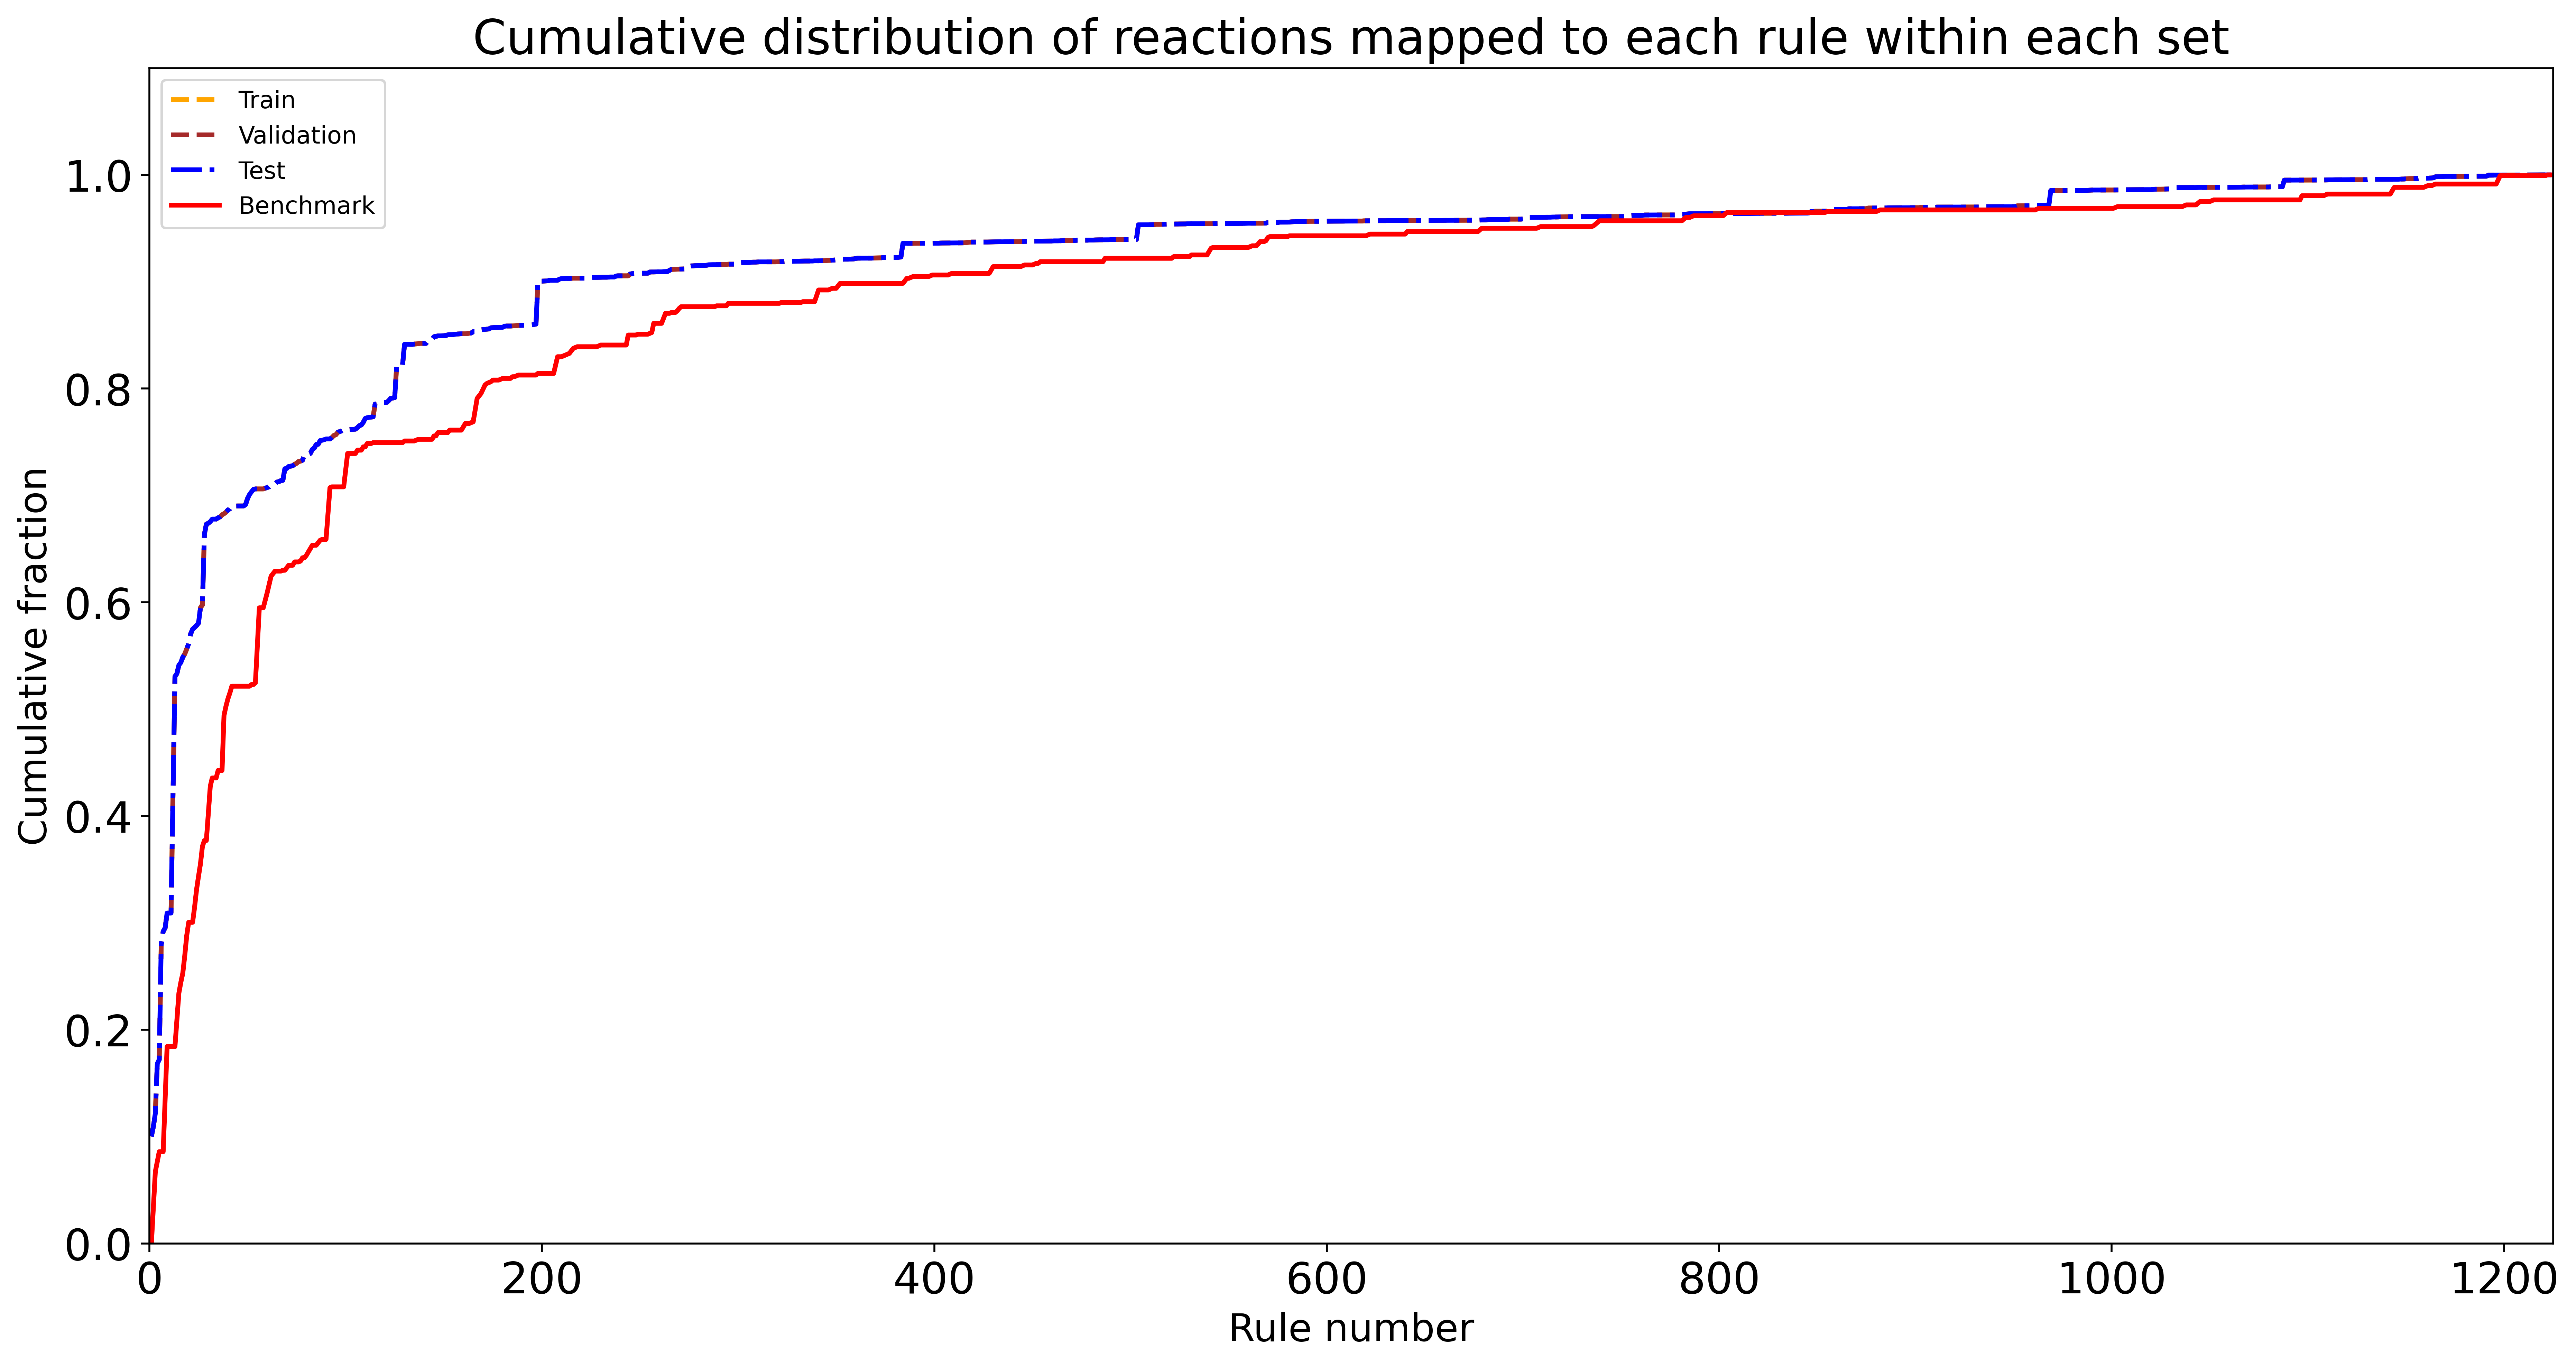

In [18]:
plt.figure(figsize=(15, 8))
plt.plot(all_rule_numbers_train, CDF_train, linestyle = 'dashed', color = 'orange', label = 'Train')
plt.plot(all_rule_numbers_val, CDF_val, linestyle = 'dashed', color = 'brown', label = 'Validation')
plt.plot(all_rule_numbers_test, CDF_test, linestyle = 'dashdot', color = 'blue', label = 'Test')
plt.plot(all_rule_numbers_benchmark, CDF_benchmark, color = 'red', label = 'Benchmark')
plt.legend()
plt.xlim([0,1225])
plt.ylim([0,1.1])
plt.xlabel('Rule number', fontsize = 16);
plt.ylabel('Cumulative fraction', fontsize = 16);
plt.title('Cumulative distribution of reactions mapped to each rule within each set', fontsize = 20);
plt.savefig('rules_CDF.png')
plt.show()

In [19]:
fig, axs = plt.subplots(4, 1, figsize=(25, 12), sharex = True, sharey = True)

# plot reaction rule distribution for training set
axs[0].bar(all_rule_numbers_train, PDF_train)
axs[0].set_ylim(0, 0.15)
axs[0].set_ylabel('Normalized\nfrequency', fontsize = 25)
axs[0].set_xticks([])
axs[0].text(x = 1224, y = 0.14, s = '(A) Training set', fontsize = 25,
            verticalalignment = 'top', horizontalalignment = 'right')

# plot 
axs[1].bar(all_rule_numbers_test, PDF_test)
axs[1].set_ylim(0, 0.15)
axs[1].set_ylabel('Normalized\nfrequency', fontsize = 25)
axs[1].set_xticks([])
axs[1].text(x = 1224, y = 0.14, s = '(B) Testing set', fontsize = 25,
            verticalalignment = 'top', horizontalalignment = 'right')

axs[2].bar(all_rule_numbers_val, PDF_val)
axs[2].set_ylim(0, 0.15)
axs[2].set_ylabel('Normalized\ncfrequency', fontsize = 25)
axs[2].set_xticks([])
axs[2].text(x = 1224, y = 0.14, s = '(C) Validation set', fontsize = 25,
            verticalalignment = 'top', horizontalalignment = 'right')

axs[3].bar(all_rule_numbers_benchmark, PDF_benchmark)
axs[3].set_ylim(0, 0.15)
axs[3].set_xlabel('Rule number', fontsize = 25)
axs[3].set_ylabel('Normalized\nfrequency', fontsize = 25)
axs[3].set_xticks([0, 200, 400, 600, 800, 1000, 1200])
axs[3].text(x = 1224, y = 0.14, s = '(D) Benchmarking set', fontsize = 25,
            verticalalignment = 'top', horizontalalignment = 'right')

plt.savefig('rule_counts_PDF.png')
plt.show()

In [20]:
train_rules = [int(rule.lstrip('rule')) for rule in training_rules_df["Rule"]]
val_rules = [int(rule.lstrip('rule')) for rule in validation_rules_df["Rule"]]
test_rules = [int(rule.lstrip('rule')) for rule in testing_rules_df["Rule"]]
benchmarking_rules = [int(rule.lstrip('rule')) for rule in M24_benchmarking_df["Rule"]]

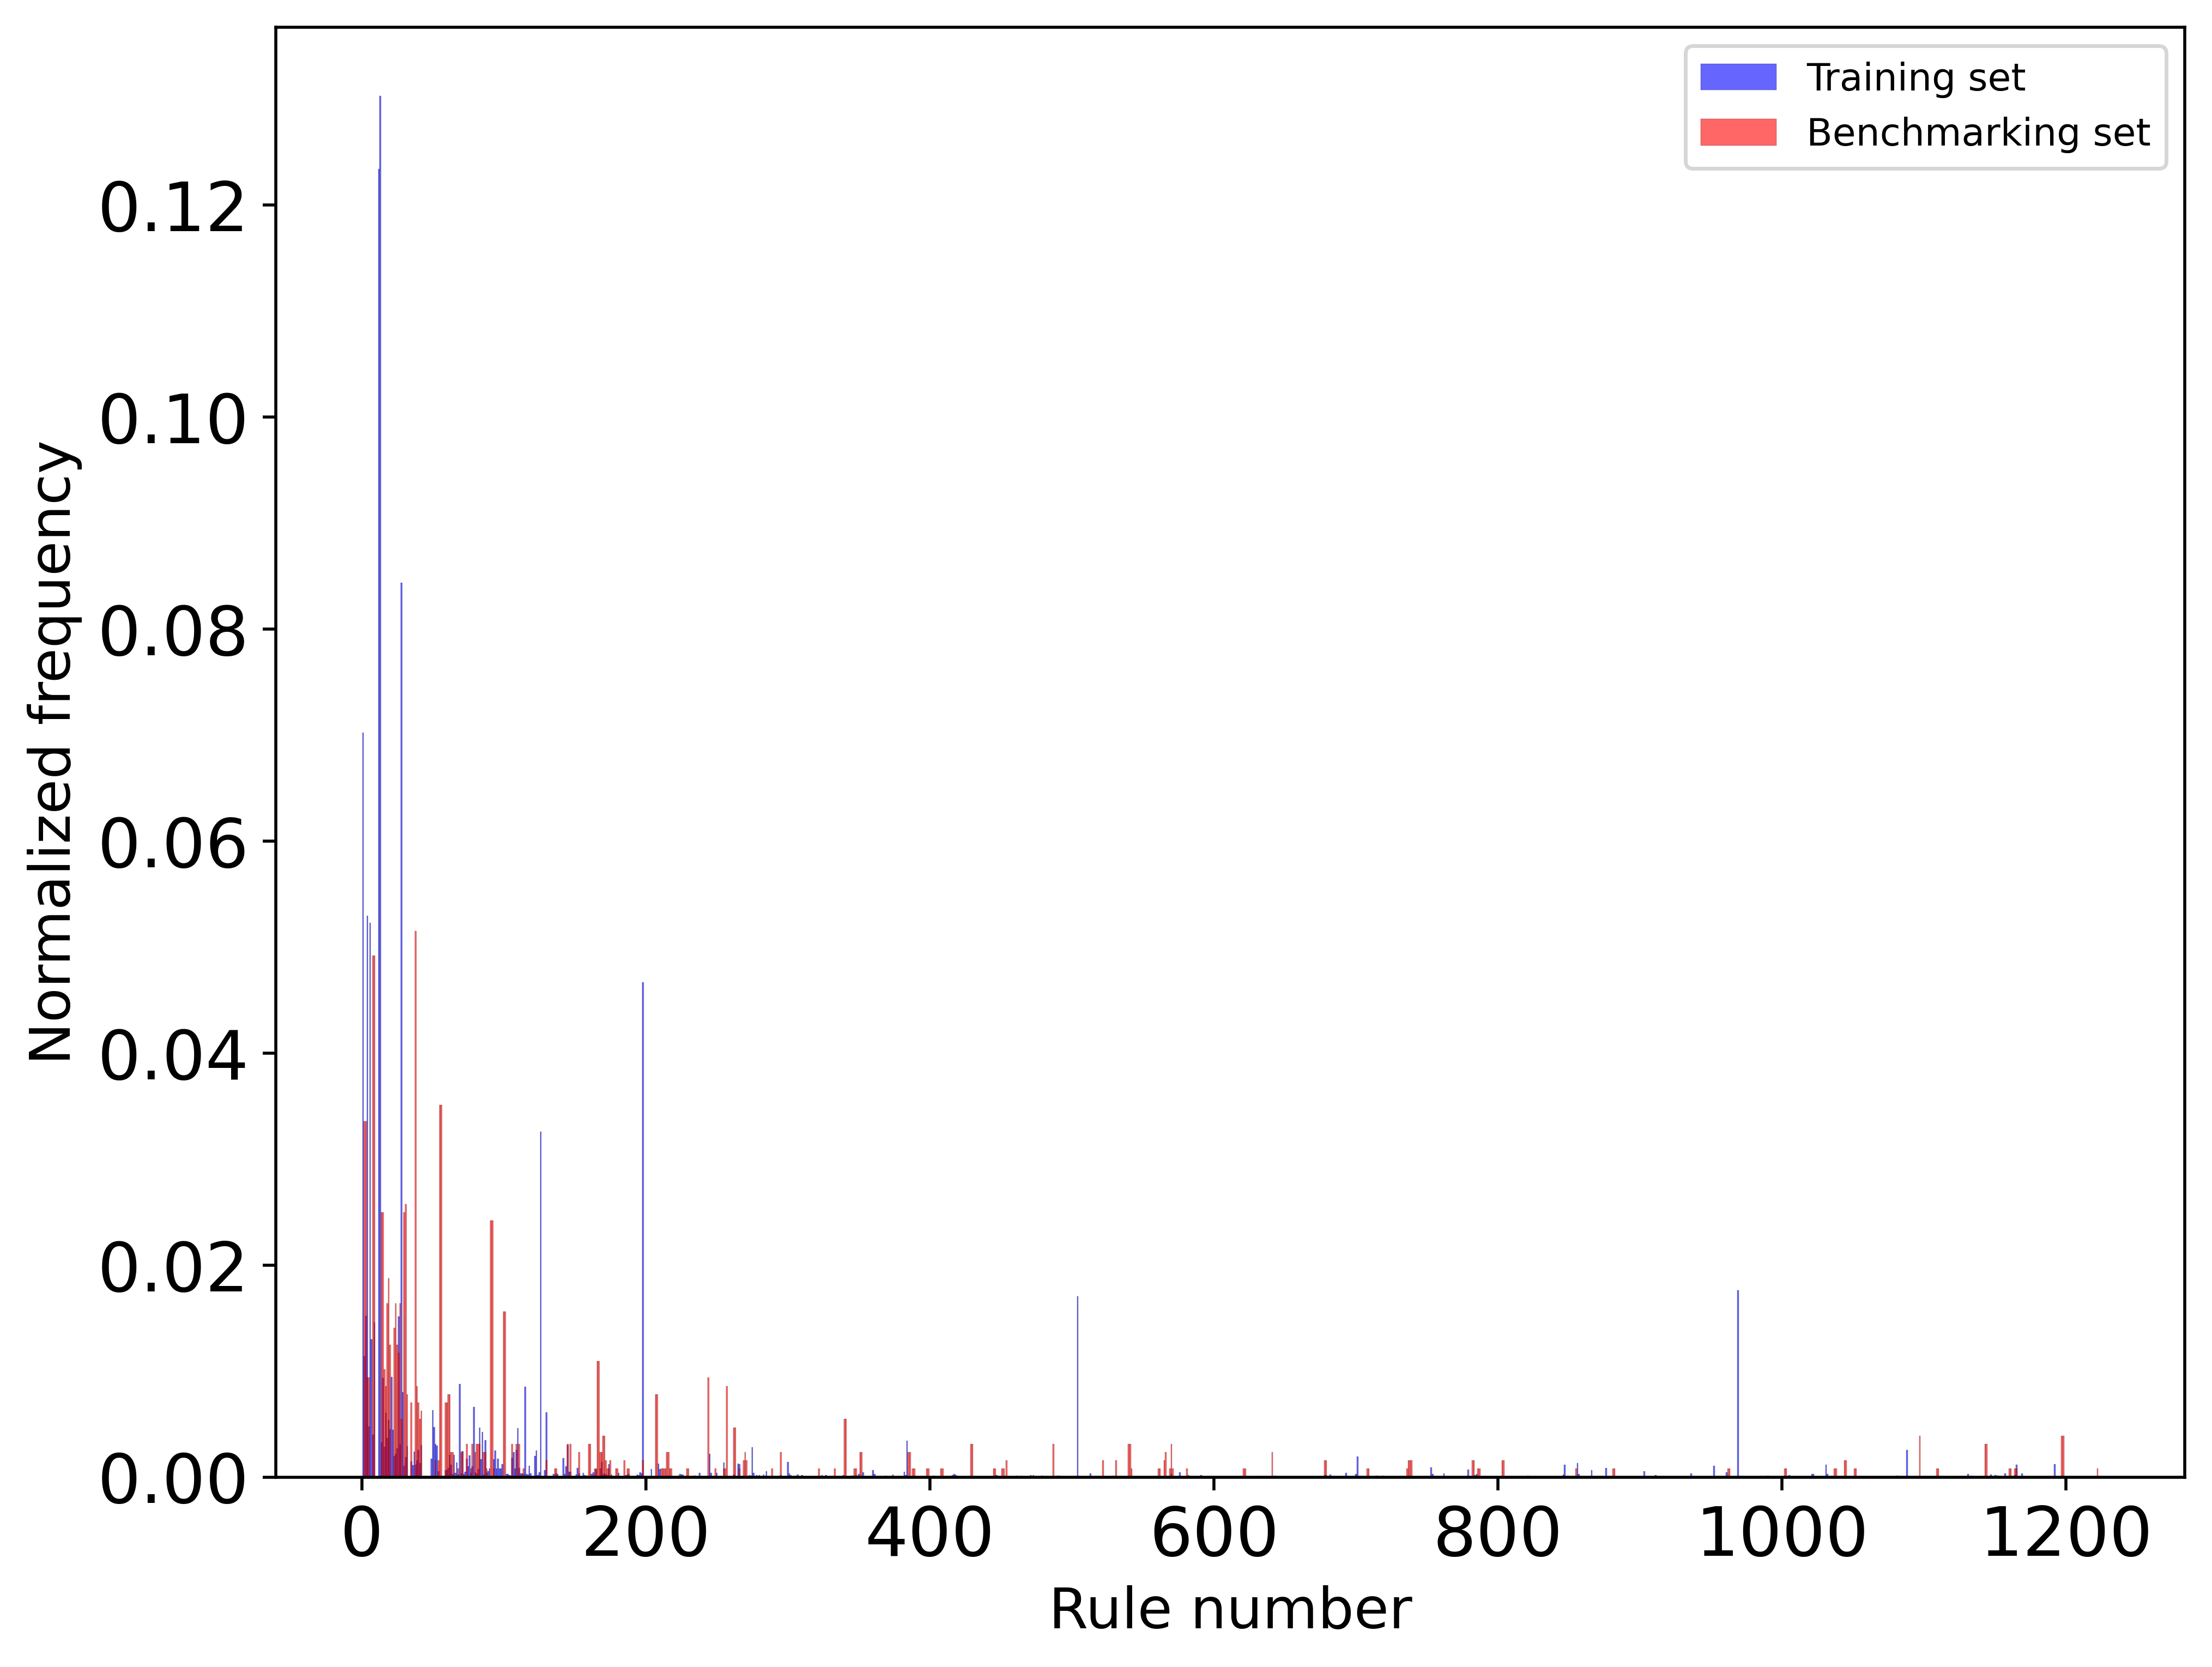

In [41]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.figure(figsize = (8, 6), constrained_layout = True)

sns.histplot(train_rules, discrete = True, color = 'blue', label = 'Training set', stat = 'probability', alpha = 0.6)
sns.histplot(benchmarking_rules, discrete = True, color = 'red', label = 'Benchmarking set', stat = 'probability', alpha = 0.6)
plt.xlabel('Rule number', fontsize = 15)
plt.ylabel('Normalized frequency', fontsize = 15)
plt.legend()

plt.savefig('train_vs_benchmark_rules_PDF.png')
plt.show()

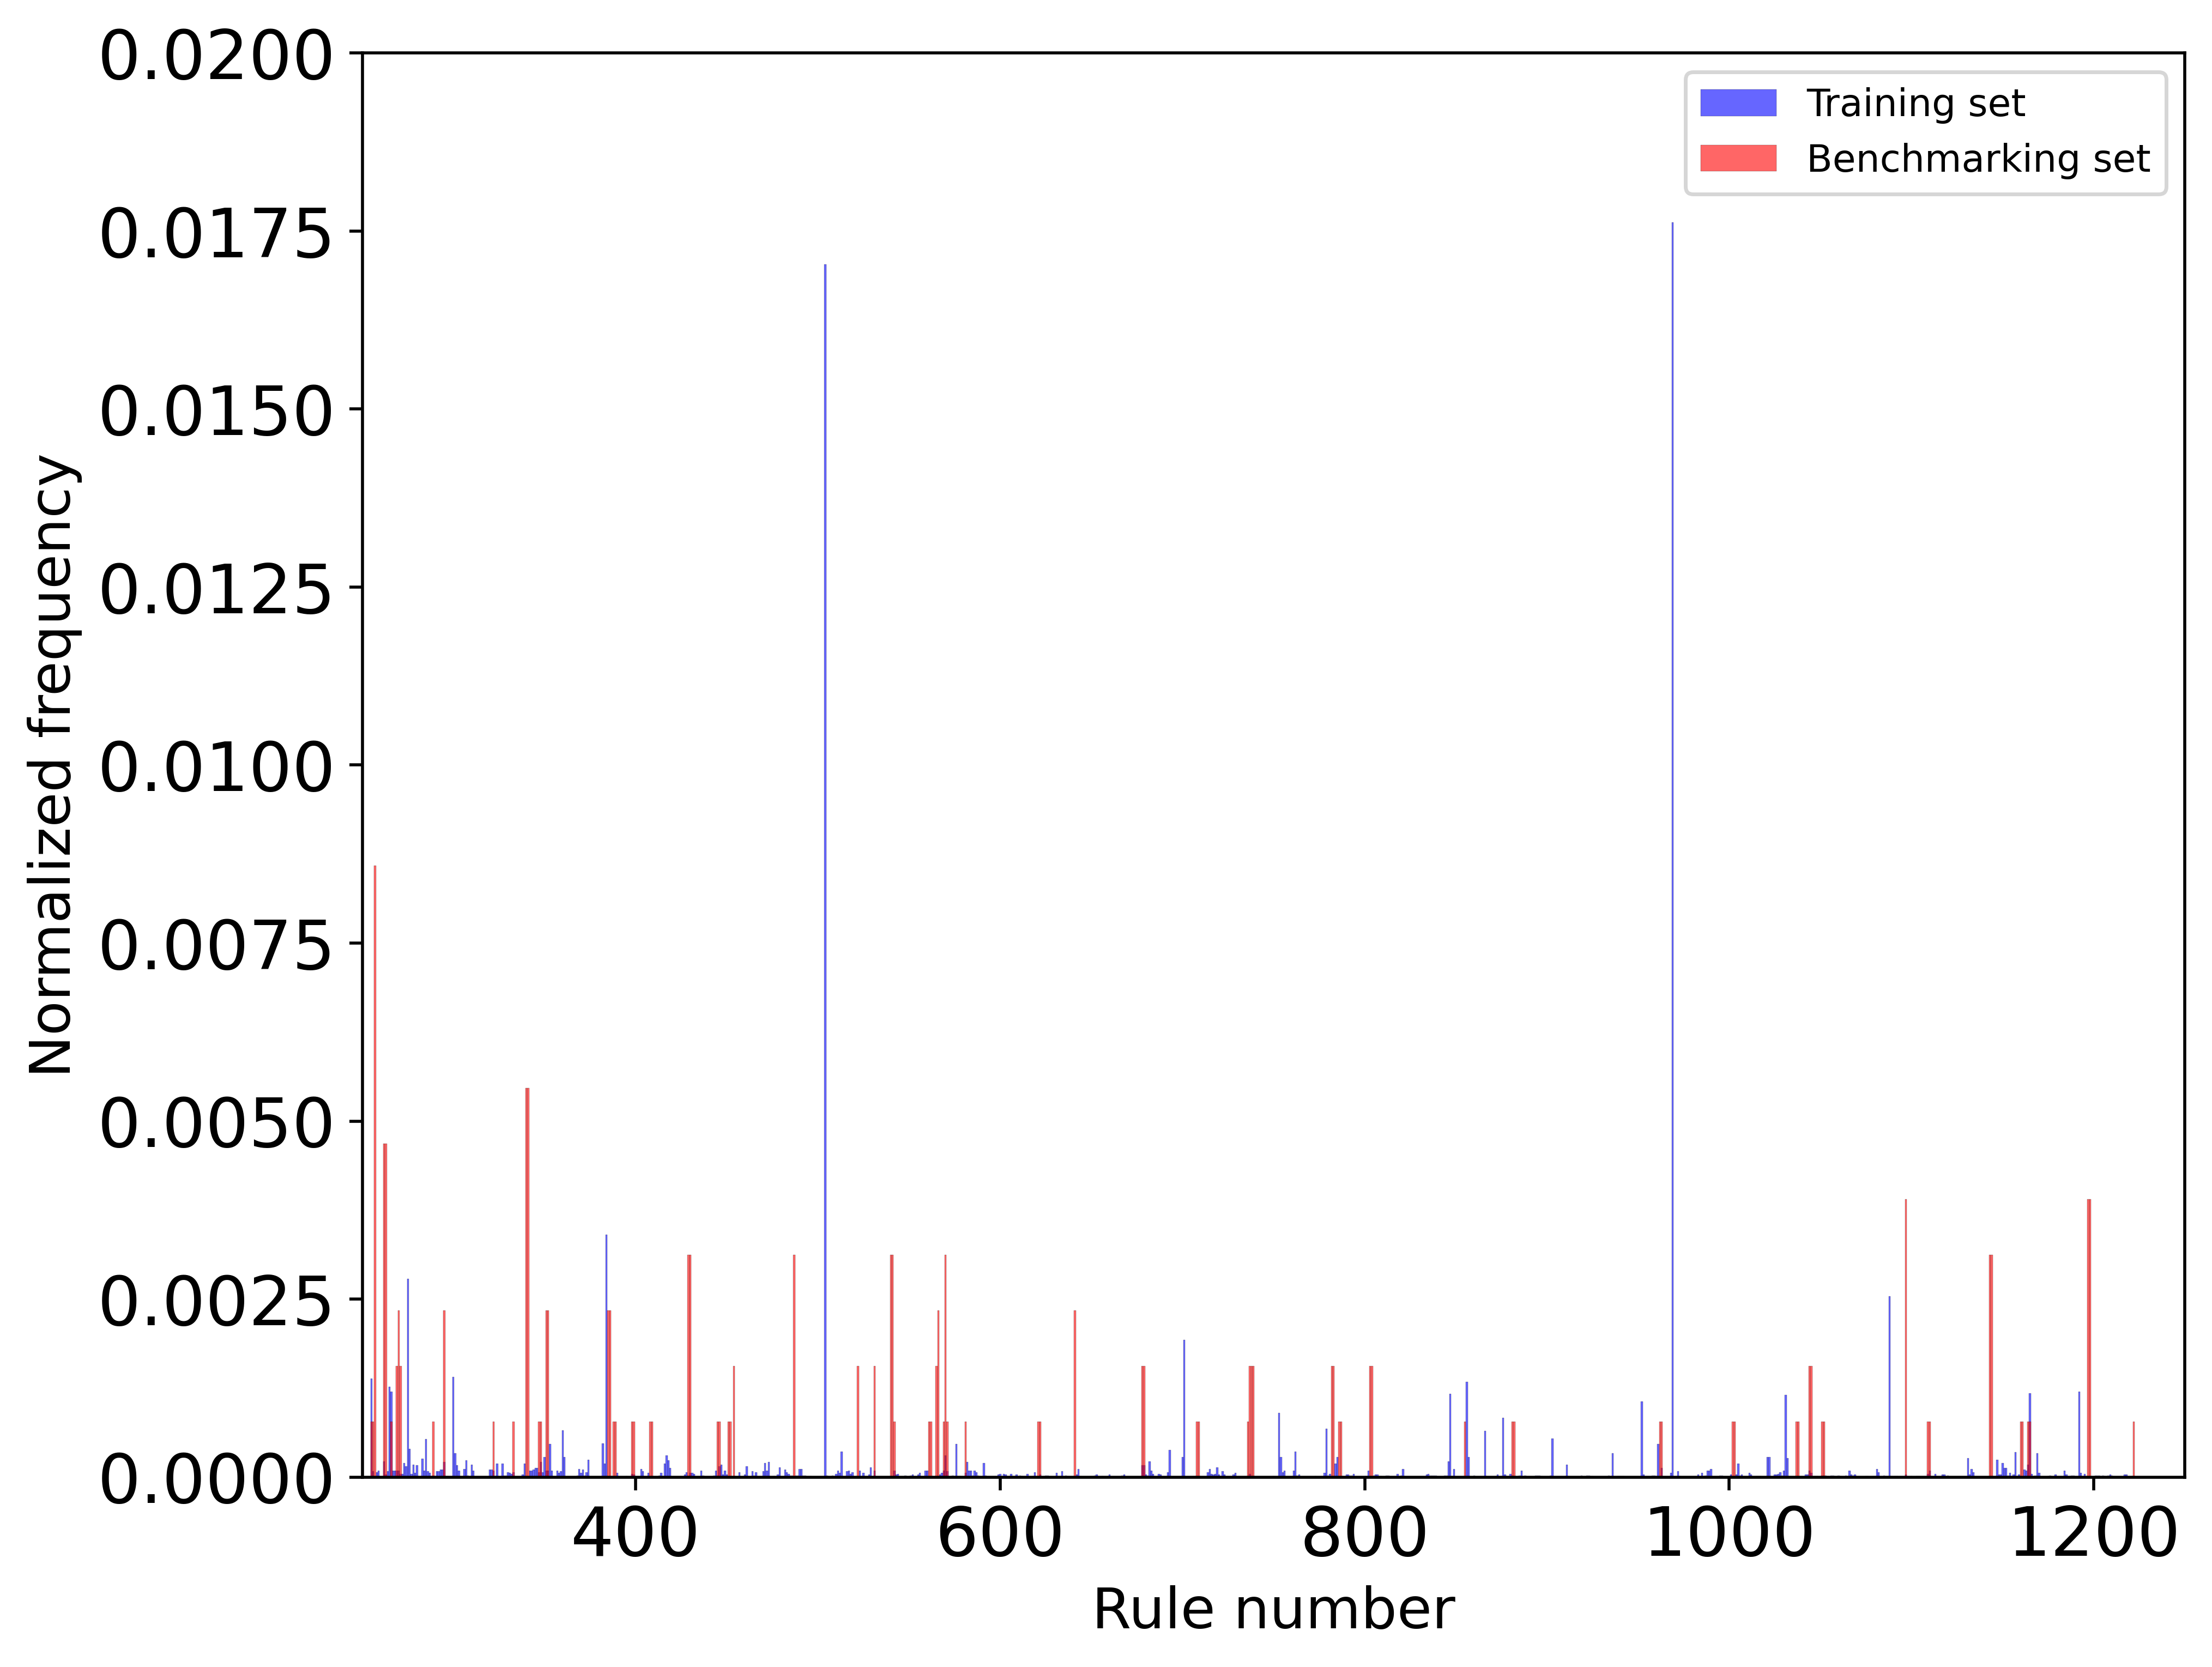

In [42]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.figure(figsize = (8, 6), constrained_layout = True)

sns.histplot(train_rules, discrete = True, color = 'blue', label = 'Training set', stat = 'probability', alpha = 0.6)
sns.histplot(benchmarking_rules, discrete = True, color = 'red', label = 'Benchmarking set', stat = 'probability', alpha = 0.6)
plt.xlabel('Rule number', fontsize = 15)
plt.ylabel('Normalized frequency', fontsize = 15)
plt.xlim([250,1250])
plt.ylim([0,0.02])
plt.legend()

plt.savefig('train_vs_benchmark_rules_PDF_zooomed_in.png')
plt.show()